In [1]:
# load libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import glob 
import os
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA, FactorAnalysis

# see process_data.py
import process_data as data

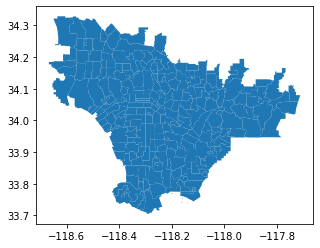

In [50]:
# load processed zipcodes (see r files)
zipcodes_shp = os.path.join("..", "processed", "collapsed_measures", "zipcodes_processed.shp") 
zipcodes = gpd.read_file(zipcodes_shp) 

zipcodes.plot()
plt.show()

In [8]:
# load prev data from zipcode_pca_data
pca_path = os.path.join("..", "processed", "sociodemographic_data", "pca_acs.csv")
pca_data = pd.read_csv(pca_path)


In [111]:
# check if zipcodes match up with shp's
print(zipcodes["ZIPCODE"].shape)
print(pca_data["ZIPCODE"].shape)

(257,)
(250,)


In [121]:
# filter zipcodes to only include zipcodes covered by pca_data
zipcodes_to_keep = list(pca_data["ZIPCODE"].astype(str))
filtered_zipcodes = zipcodes[zipcodes.loc[:, "ZIPCODE"].isin(zipcodes_to_keep)]

In [123]:
filtered_zipcodes.reset_index(drop=True, inplace=True)

In [125]:
# check that zipcodes of pca data and shp file are the same (will use shp later)
filtered_zipcodes["ZIPCODE"].equals(pca_data["ZIPCODE"].astype(str))

True

In [7]:
print(pca_data.shape)
print(pca_data.columns)

(250, 21)
Index(['ZIPCODE', 'ForeignBorn', 'Unemployment', 'WorkOutdoors', 'TotalPop',
       'WhitePop', 'BlackPop', 'AsianPop', 'NativePop', 'HispanicLatino',
       'Elderly', 'Children', 'Renting', 'LiveAlone', 'LiveAloneElderly',
       'LessThanHS', 'MaxHS', 'ExtremePoverty', 'ManyOccupants', 'Overcrowded',
       'Solar'],
      dtype='object')


In [126]:
pca_df = pca_data.drop(columns=["ZIPCODE", "TotalPop"])
pca_df.columns 

Index(['ForeignBorn', 'Unemployment', 'WorkOutdoors', 'WhitePop', 'BlackPop',
       'AsianPop', 'NativePop', 'HispanicLatino', 'Elderly', 'Children',
       'Renting', 'LiveAlone', 'LiveAloneElderly', 'LessThanHS', 'MaxHS',
       'ExtremePoverty', 'ManyOccupants', 'Overcrowded', 'Solar'],
      dtype='object')

In [127]:
numeric_df = pd.DataFrame()
for i in pca_df.columns:
    numeric_df[i] = pd.to_numeric(pca_df[i], errors="coerce") # convert strs ("-") into nan

In [128]:
# mask nas with col's mean to preserve data shape: https://medium.com/writing-data/basic-data-cleaning-removing-nans-1787110fc11b
masked_df = numeric_df.fillna(numeric_df.mean(axis=0))

In [129]:
scaled = pd.DataFrame()
for i in masked_df.columns:
    scaled[i] = scale(masked_df[i]) 

x = scaled.values
print(np.isnan(x).any())

False


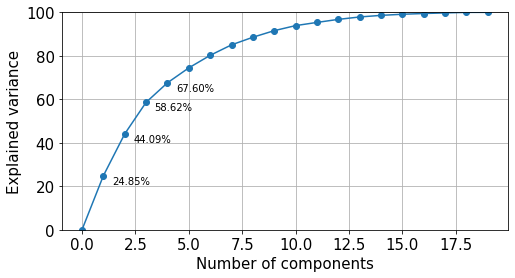

In [130]:
# run on all vars
pca_full = PCA(n_components=len(scaled.columns))
pca_full.fit(x)

explained_variance = np.cumsum(pca_full.explained_variance_ratio_ * 100) # ratio = eigenval / sum(eigenvals)
# Create an array with a zero at the beginning
explained_variance = np.concatenate([[0], explained_variance])

plt.figure(figsize=(8, 4))
plt.plot(explained_variance, marker='o')
# Add big black markers at each point
plt.scatter(range(len(explained_variance)), explained_variance, s=10, color='black')

plt.ylim(0,100)
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.grid()

# Add text annotations for explained variance numbers
for i, var in enumerate(explained_variance[1:5]):
    plt.text(i+1.4, var, f'{var:.2f}%', fontsize=10, ha='left', va='top')

plt.show()

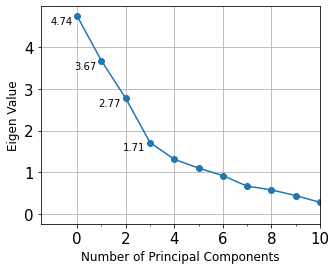

In [131]:
# plot eigenvals
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(1, 1, 1)

# Plot the explained variance
plt.plot(pca_full.explained_variance_, marker='o')

# # Add big black markers at each point
# plt.scatter(range(len(pca_full.explained_variance_)), pca_full.explained_variance_, s=10, color='black', label='Markers')

plt.xlabel('Number of Principal Components', fontsize=12)
plt.ylabel('Eigen Value', fontsize=12)

# Add text annotations for explained variance numbers
for i, var in enumerate(pca_full.explained_variance_[:4]):
    plt.text(i-.2, var, f'{var:.2f}', fontsize=10, ha='right', va='top')
ax.set_xticks(np.arange(0, 23, 1), minor=True)
plt.xlim(-1.5,10)
plt.grid()
plt.show()

In [132]:
pca_3 = PCA(n_components = 4) # select 3 components
PC3 = pca_3.fit_transform(x) # we apply the PCA to x, this returns the an array of scores (og data projected onto new basis)

print('Number of components:', pca_3.n_components_)
print('Number of features:', pca_3.n_features_in_) # aka number cols 
print('Number of samples:', pca_3.n_samples_) # aka number of rows 

Number of components: 4
Number of features: 19
Number of samples: 250


In [133]:
scores = pd.DataFrame(data = PC3, columns = ['PC1','PC2','PC3', 'PC4']) 
scores.head().style.format(precision=2)
print(scores.head())

        PC1       PC2       PC3       PC4
0  4.049102  0.203039 -1.310041 -0.577619
1  3.814869  0.709624 -0.496736 -0.369876
2  3.702544  0.230817 -1.075626 -0.332117
3  1.018464 -0.134694  0.134971 -0.186873
4  1.609741  0.015352 -0.540018  0.218666


In [134]:
# get componenets matrix
components = pd.DataFrame(data = pca_3.components_.T, columns = ['PC1','PC2','PC3', 'PC4'], index = scaled.columns)
print(components)

                       PC1       PC2       PC3       PC4
ForeignBorn      -0.168456  0.344578 -0.267502  0.218649
Unemployment      0.149654  0.247879  0.414134 -0.095668
WorkOutdoors      0.376865 -0.032348 -0.272460 -0.104645
WhitePop         -0.213222  0.328311 -0.286796 -0.013938
BlackPop          0.080116  0.115976  0.165219  0.058626
AsianPop         -0.185926 -0.130360  0.063394  0.130627
NativePop         0.224094  0.255447  0.268826 -0.041682
HispanicLatino    0.399019  0.021222 -0.235802 -0.083373
Elderly          -0.226702  0.106733 -0.150936  0.513974
Children          0.243667 -0.260936 -0.139256 -0.125378
Renting          -0.163796  0.285898 -0.302637 -0.408836
LiveAlone        -0.117771  0.327991 -0.166812 -0.481731
LiveAloneElderly  0.007718  0.400382  0.206140  0.100105
LessThanHS        0.349036  0.179402 -0.170499  0.213933
MaxHS             0.211751  0.076274 -0.318934  0.372592
ExtremePoverty    0.218021  0.282244  0.281245  0.045864
ManyOccupants    -0.144173 -0.2

In [135]:
# get variance, aka eigenval, of each pc
eig = scores.var()
print(eig) 

PC1    4.739746
PC2    3.671383
PC3    2.771364
PC4    1.712553
dtype: float64


In [40]:
loadings = components.mul(np.sqrt(pca_3.explained_variance_))
print(loadings)

# each column entry = weight of the og variable in contributing to pc


                       PC1       PC2       PC3       PC4
ForeignBorn      -0.366744  0.660242 -0.445321  0.286134
Unemployment      0.325812  0.474958  0.689426 -0.125195
WorkOutdoors      0.820471 -0.061982 -0.453575 -0.136943
WhitePop         -0.464204  0.629072 -0.477441 -0.018240
BlackPop          0.174421  0.222221  0.275047  0.076721
AsianPop         -0.404778 -0.249780  0.105534  0.170944
NativePop         0.487873  0.489459  0.447527 -0.054547
HispanicLatino    0.868702  0.040663 -0.392550 -0.109106
Elderly          -0.493552  0.204510 -0.251270  0.672609
Children          0.530487 -0.499976 -0.231825 -0.164076
Renting          -0.356600  0.547805 -0.503812 -0.535022
LiveAlone        -0.256399  0.628458 -0.277698 -0.630415
LiveAloneElderly  0.016802  0.767165  0.343170  0.131002
LessThanHS        0.759886  0.343749 -0.283837  0.279963
MaxHS             0.461002  0.146147 -0.530943  0.487591
ExtremePoverty    0.474652  0.540804  0.468200  0.060020
ManyOccupants    -0.313879 -0.3

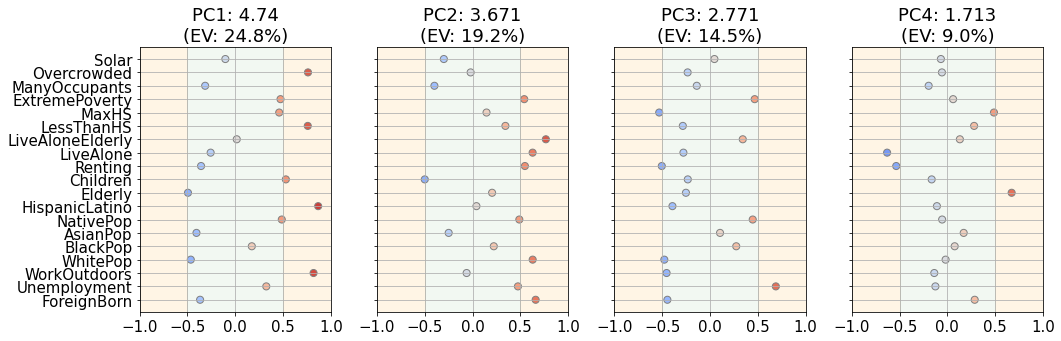

In [176]:
fig,[ax1,ax2,ax3, ax4] = plt.subplots(1,4, figsize=(15,5), sharey=True, tight_layout=True)
# fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(10,10), sharey=True, sharex=True, tight_layout=True)
ax1.grid()
ax1.axvspan(xmin=-1, xmax=-0.5, color='orange', alpha=0.1)
ax1.axvspan(xmin=-0.5, xmax=0.5, color='green', alpha=0.05)
ax1.axvspan(xmin=0.5, xmax=1, color='orange', alpha=0.1)
ax1.scatter(loadings.PC1, loadings.index, c=loadings.PC1, cmap='coolwarm', vmin=-1, vmax=1, edgecolors='grey', s=50)
ax1.set_title('PC1: ' + str(round(pca_3.explained_variance_[0],3)) + '\n(EV: ' +
              str(round(pca_3.explained_variance_ratio_[0]*100,1)) + '%)')
ax1.set_xlim([-1,1])

ax2.grid()
ax2.axvspan(xmin=-1, xmax=-0.5, color='orange', alpha=0.1)
ax2.axvspan(xmin=-0.5, xmax=0.5, color='green', alpha=0.05)
ax2.axvspan(xmin=0.5, xmax=1, color='orange', alpha=0.1)
ax2.scatter(loadings.PC2, loadings.index, c=loadings.PC2, cmap='coolwarm', vmin=-1, vmax=1, edgecolors='grey', s=50)
ax2.set_title('PC2: ' + str(round(pca_3.explained_variance_[1],3)) + '\n(EV: ' +
              str(round(pca_3.explained_variance_ratio_[1]*100,1)) + '%)')
ax2.set_xlim([-1,1])

ax3.grid()
ax3.axvspan(xmin=-1, xmax=-0.5, color='orange', alpha=0.1)
ax3.axvspan(xmin=-0.5, xmax=0.5, color='green', alpha=0.05)
ax3.axvspan(xmin=0.5, xmax=1, color='orange', alpha=0.1)
ax3.scatter(loadings.PC3, loadings.index, c=loadings.PC3, cmap='coolwarm', vmin=-1, vmax=1, edgecolors='grey', s=50)
ax3.set_title('PC3: ' + str(round(pca_3.explained_variance_[2],3)) + '\n(EV: ' +
              str(round(pca_3.explained_variance_ratio_[2]*100,1)) + '%)')
ax3.set_xlim([-1,1])

ax4.grid()
ax4.axvspan(xmin=-1, xmax=-0.5, color='orange', alpha=0.1)
ax4.axvspan(xmin=-0.5, xmax=0.5, color='green', alpha=0.05)
ax4.axvspan(xmin=0.5, xmax=1, color='orange', alpha=0.1)
ax4.scatter(loadings.PC4, loadings.index, c=loadings.PC4, cmap='coolwarm', vmin=-1, vmax=1, edgecolors='grey', s=50)
ax4.set_title('PC4: ' + str(round(pca_3.explained_variance_[3],3)) + '\n(EV: ' +
              str(round(pca_3.explained_variance_ratio_[3]*100,1)) + '%)')
ax4.set_xlim([-1,1])
plt.show()

In [137]:
scores[["ZIPCODE", "geometry"]] = filtered_zipcodes[["ZIPCODE", "geometry"]]

In [155]:
scores.shape

(250, 6)

In [161]:
gdf = gpd.GeoDataFrame(scores, geometry=scores.geometry).set_index("ZIPCODE")
gdf.loc[:,'PC1_z'] = scale(gdf['PC1'])
gdf.loc[:,'PC2_z'] = scale(gdf['PC2'])
gdf.loc[:,'PC3_z'] = scale(gdf['PC3'])
gdf.loc[:,'PC4_z'] = scale(gdf['PC4'])
gdf.head()

,PC1,PC2,PC3,PC4,geometry,PC1_z,PC2_z,PC3_z,PC4_z
ZIPCODE,,,,,,,,,
90001,4.049102,0.203039,-1.310041,-0.577619,"POLYGON ((-118.24338 33.98924, -118.24333 33.9...",1.863595,0.106178,-0.788512,-0.442272
90002,3.814869,0.709624,-0.496736,-0.369876,"POLYGON ((-118.23431 33.96101, -118.23425 33.9...",1.755789,0.371094,-0.298985,-0.283207
90003,3.702544,0.230817,-1.075626,-0.332117,"POLYGON ((-118.28285 33.97597, -118.28285 33.9...",1.704092,0.120705,-0.647418,-0.254296
90004,1.018464,-0.134694,0.134971,-0.186873,"POLYGON ((-118.28410 34.08349, -118.28425 34.0...",0.468747,-0.070438,0.081239,-0.143085
90005,1.609741,0.015352,-0.540018,0.218666,"MULTIPOLYGON (((-118.33541 34.06179, -118.3350...",0.740881,0.008028,-0.325036,0.167429


In [162]:
# get sensitivity scores!!
gdf['sen'] = gdf['PC1_z']*eig[0]/eig.sum() + gdf['PC2_z']*eig[1]/eig.sum() + gdf['PC3_z']*eig[2]/eig.sum() + gdf['PC4_z']*eig[3]/eig.sum()
gdf.head()

C:\Users\scarl\AppData\Local\Temp\ipykernel_22760\424352586.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gdf['sen'] = gdf['PC1_z']*eig[0]/eig.sum() + gdf['PC2_z']*eig[1]/eig.sum() + gdf['PC3_z']*eig[2]/eig.sum() + gdf['PC4_z']*eig[3]/eig.sum()


,PC1,PC2,PC3,PC4,geometry,PC1_z,PC2_z,PC3_z,PC4_z,sen
ZIPCODE,,,,,,,,,,
90001,4.049102,0.203039,-1.310041,-0.577619,"POLYGON ((-118.24338 33.98924, -118.24333 33.9...",1.863595,0.106178,-0.788512,-0.442272,0.487018
90002,3.814869,0.709624,-0.496736,-0.369876,"POLYGON ((-118.23431 33.96101, -118.23425 33.9...",1.755789,0.371094,-0.298985,-0.283207,0.649150
90003,3.702544,0.230817,-1.075626,-0.332117,"POLYGON ((-118.28285 33.97597, -118.28285 33.9...",1.704092,0.120705,-0.647418,-0.254296,0.487814
90004,1.018464,-0.134694,0.134971,-0.186873,"POLYGON ((-118.28410 34.08349, -118.28425 34.0...",0.468747,-0.070438,0.081239,-0.143085,0.150697
90005,1.609741,0.015352,-0.540018,0.218666,"MULTIPOLYGON (((-118.33541 34.06179, -118.3350...",0.740881,0.008028,-0.325036,0.167429,0.226986


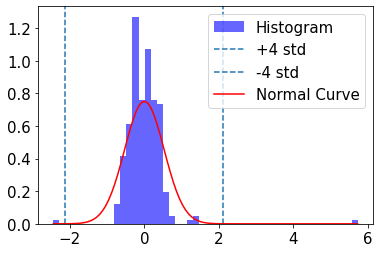

In [163]:
mean = gdf['sen'].mean()
std = gdf['sen'].std()

x = np.linspace(gdf['sen'].min(), gdf['sen'].max(), 100) # create array of x-values for normal curve
y = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std) ** 2) # calculate y-values for normal distribution

plt.hist(gdf['sen'], bins=50, density=True, alpha=0.6, color='blue', label='Histogram') # create the histogram
plt.axvline(mean + 4*std, linestyle='--', label='+4 std')
plt.axvline(mean - 4*std, linestyle='--', label='-4 std')
plt.plot(x, y, color='red', label='Normal Curve') # plot the normal curve
plt.legend()
plt.show()

In [164]:
gdf[gdf['sen'] > mean + 4*std]

,PC1,PC2,PC3,PC4,geometry,PC1_z,PC2_z,PC3_z,PC4_z,sen
ZIPCODE,,,,,,,,,,
90071,6.150171,19.043842,15.099764,-0.938485,"POLYGON ((-118.25502 34.05547, -118.25493 34.0...",2.83061,9.95887,9.088531,-0.71858,5.733691


In [165]:
gdf[gdf['sen'] < mean - 4*std]

,PC1,PC2,PC3,PC4,geometry,PC1_z,PC2_z,PC3_z,PC4_z,sen
ZIPCODE,,,,,,,,,,
91608,-9.000099,12.51353,-10.272429,-14.35093,"POLYGON ((-118.34505 34.14245, -118.34502 34.1...",-4.142286,6.54388,-6.182964,-10.988245,-2.447567


In [168]:
gdf = gdf.drop(['90071', '91608'], axis=0)
gdf.shape

KeyError: "['90071', '91608'] not found in axis"

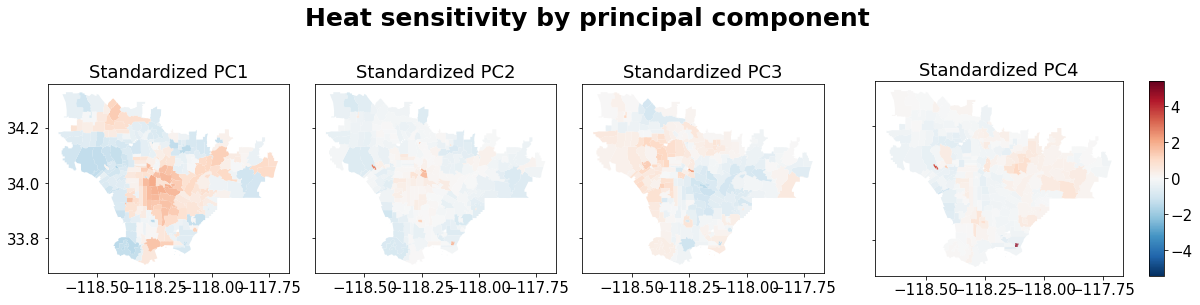

In [169]:
# plot standardized pcs
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1,4, figsize=(20,5), sharey=True, gridspec_kw={'width_ratios': [1, 1, 1, 1.3]})

vmin_z = min(gdf[['PC1_z','PC2_z','PC3_z', 'PC4_z']].min()) # redefine min and max values for _z variables
vmax_z = max(gdf[['PC1_z','PC2_z','PC3_z', 'PC4_z']].max())
abs_vmax_z = max(abs(vmin_z), abs(vmax_z)) # find absolute max to center colorbar on 0
vmin_z = -abs_vmax_z*0.8 # note the *0.8 to shorten the color range slightly (otherwise map is very white)
vmax_z = abs_vmax_z*0.8

gdf.plot(column='PC1_z', cmap='RdBu_r', ax=ax[0], vmin=vmin_z, vmax=vmax_z)
ax[0].set_title('Standardized PC1')
gdf.plot(column='PC2_z', cmap='RdBu_r', ax=ax[1], vmin=vmin_z, vmax=vmax_z)
ax[1].set_title('Standardized PC2')
gdf.plot(column='PC3_z', cmap='RdBu_r', ax=ax[2], vmin=vmin_z, vmax=vmax_z)
ax[2].set_title('Standardized PC3')
gdf.plot(column='PC4_z', cmap='RdBu_r', ax=ax[3], vmin=vmin_z, vmax=vmax_z)
ax[3].set_title('Standardized PC4')

divider = make_axes_locatable(ax[3]) # create a common colorbar
cax = divider.append_axes("right", size="5%", pad=0)

# add colorbar to the right side of the third subplot
sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=plt.Normalize(vmin=vmin_z, vmax=vmax_z))
fig.colorbar(sm, cax=cax)

plt.suptitle('Heat sensitivity by principal component', fontsize=25, fontweight='bold')
plt.subplots_adjust(wspace=0.1, hspace=0.1) # adjust spacing between subplots
plt.show()

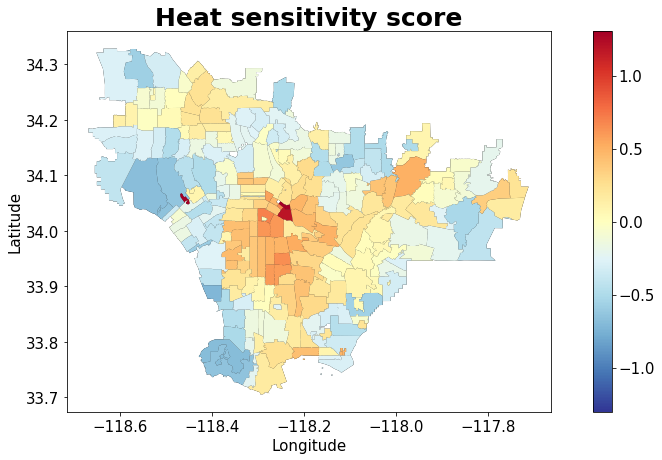

In [175]:
fig, ax = plt.subplots(figsize=(15,7))
plt.rcParams.update({'font.size': 15})
vmax = min(gdf.PC4.max(), -gdf.PC4.min()) # define vmax and vmin
vmin = -vmax

gdf.plot(ax=ax, facecolor='k', edgecolor='None')
gdf.plot(column='sen', cmap='RdYlBu_r', legend=True, ax=ax, vmin=vmin, vmax=vmax)
ax.set_title('Heat sensitivity score', fontsize=25, fontweight='bold')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()